## Using the sample of disk galaxies created in red_disk_sample.ipynb, the fraction of red disks as a function of redshift will be measured, incorporating corrections from simulated FERENGI galaxies.

In [1]:
%pylab inline
import matplotlib.gridspec as gridspec
from astropy.table import Table,Column
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter
import os

from PIL import Image
import urllib, cStringIO
import random

#function for getting galaxy images
def get_image_from_url(url):

    file = cStringIO.StringIO(urllib.urlopen(url).read())
    img = Image.open(file)
    return img


mpl.rcParams['text.usetex']=True
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20 


Populating the interactive namespace from numpy and matplotlib


In [14]:
#load the data - #70,198 galaxies matched between COSMOS and UV
data=Table.read('../data/cosmos_uv_matched_catalog.fits')

#load cut values from red_disk_sample: 
cuts=Table.read('../data/red_disk_cuts.fits')

#GZH vote fractions
p_features = 't01_smooth_or_features_a02_features_or_disk_best_fraction'
p_clumpy_no = 't12_clumpy_a02_no_weighted_fraction'
p_edgeon_no = 't02_edgeon_a02_no_weighted_fraction'
N_edgeon = 't02_edgeon_total_weight'

#define disk sample
disks = (data[p_features]>cuts['p_features_cut']) & (data[p_clumpy_no]>cuts['p_clumpy_no_cut']) & (data[p_edgeon_no]>cuts['p_edgeon_no_cut']) & (data[N_edgeon]>=cuts['N_edgeon_cut']) & (data['Z_BEST']>cuts['z_lower']) & (data['Z_BEST']<=cuts['z_upper']) & (data['MR']<cuts['mag_cut']) & (data['GZ_MU_HI']<20)
#disks = (data[p_features]>.5)  & (data[p_edgeon_no]>cuts['p_edgeon_no_cut']) & (data[N_edgeon]>=cuts['N_edgeon_cut']) & (data['Z_BEST']>cuts['z_lower']) & (data['Z_BEST']<=cuts['z_upper']) 

print 'Number of disks: %s'%len(data[disks])

#define red sequence
red_sequence = (data['classification']==0)
blue_cloud = (data['classification']==1)


Number of disks: 7497


In [4]:
#evaluate in 5 redshift bins, from 0 to 1:
z_edges = np.linspace(cuts['z_lower'],cuts['z_upper'],6)

In [15]:
#define histograms in redshift bins
def color_color(z_data):
    colorhist,xedge,yedge = np.histogram2d(z_data['MR']-z_data['MJ'],z_data['MNUV']-z_data['MR'],bins=(10,10))
    N_disks=np.sum(colorhist)
    colorhist = colorhist/N_disks
    extent=[xedge[0],xedge[-1],yedge[0],yedge[-1]]

    colorhist_contour,xedge_contour,yedge_contour = np.histogram2d(z_data['MR']-z_data['MJ'],z_data['MNUV']-z_data['MR'],bins=(15,15))
    extent_contour=[xedge_contour[0],xedge_contour[-1],yedge_contour[0],yedge_contour[-1]]
    
    return colorhist, extent, colorhist_contour, extent_contour

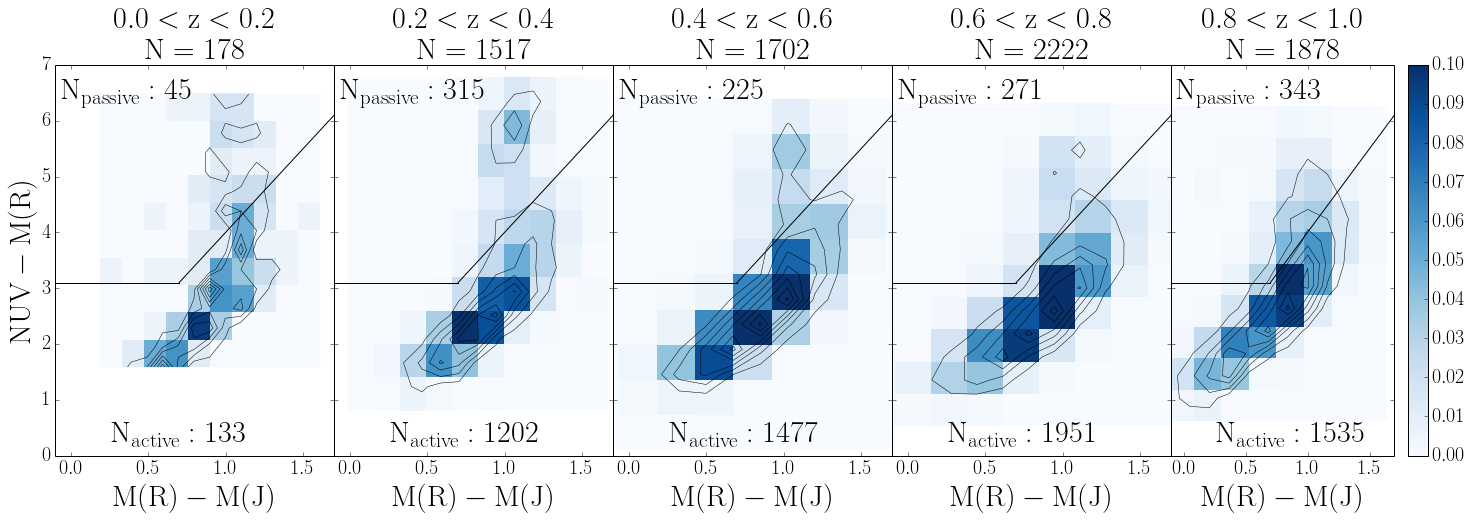

In [16]:
#plot color-color distribution in each redshift bin:
f=plt.figure(figsize=(25,7))
gs = gridspec.GridSpec(1,5)
gs.update(wspace=0)

cmap=cm.Blues
vmin = 0 
vmax = .1
x1=np.linspace(-5,.7,100)
x2=np.linspace(.7,5,100)
red_disks=[]
all_disks=[]

for i in range(0,len(z_edges)-1):
    z_bin = (data['Z_BEST']>z_edges[i]) & (data['Z_BEST']<=z_edges[i+1])
    colorhist, extent, colorhist_contour, extent_contour = color_color(data[disks & z_bin])
    
    #record number of red disks and all disks:
    red_disks.append(len(data[disks & z_bin & red_sequence]))
    all_disks.append(len(data[disks & z_bin]))
    ax = plt.subplot(gs[0,i])
    plt.contour(colorhist_contour.T,extent=extent_contour,colors='k',linewidths=.5)
    plt.imshow(colorhist.T,origin='lower',extent=extent,interpolation='nearest',cmap=cmap,aspect='auto',vmin=vmin,vmax=vmax)
    ax.annotate('$\mathrm{N_{passive}: %s}$'%red_disks[i],fontsize=30,xy=(0.02,.9),
            xycoords='axes fraction')
    ax.annotate('$\mathrm{N_{active}: %s}$'%(all_disks[i]-red_disks[i]),fontsize=30,xy=(0.2,.02),
            xycoords='axes fraction')

    plt.ylim(0,7)
    plt.xlim(-.1,1.7)
    plt.plot(x1,3.1+0*x1,c='k')
    plt.plot(x2,3*x2+1,c='k')
    plt.title('$\mathrm{%s<z<%s}$\n$\mathrm{N=%s}$'%(z_edges[i],z_edges[i+1],int(all_disks[i])),fontsize=30)

    if i==0:
        plt.ylabel('$\mathrm{NUV-M(R)}$',fontsize=30)
    else:
        plt.tick_params(labelleft='off')
    plt.xlabel('$\mathrm{M(R)-M(J)}$',fontsize=30)
   
    if i==4:
        plt.colorbar()
        


In [17]:
len(data[disks])

7497

In [18]:
np.sum(all_disks)

7497

In [19]:
f_list = []
for i in range(0,len(red_disks)):
    f_list.append(float(red_disks[i])/all_disks[i])

In [20]:
red_bins = [.1,.3,.5,.7,.9]

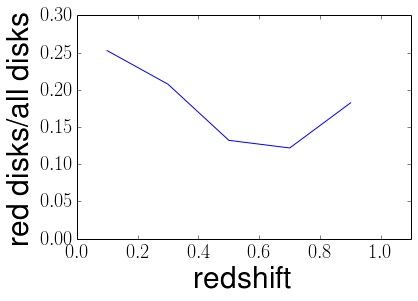

In [21]:
plt.plot(red_bins,f_list)
plt.ylim(0,.3)
plt.xlim(0,1.1)
plt.xlabel('redshift',fontsize = 30)
plt.ylabel('red disks/all disks', fontsize=30)